In [1]:
%config InlineBackend.figure_formats = ['svg']
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
from argparse import ArgumentParser
import torch
import pytorch_lightning as pl
from torch_geometric.loader import DataLoader

from datasets import ArgoverseV2Dataset
from predictors import QCNet
from predictors.autoval import AntoQCNet
from transforms import TargetBuilder

pl.seed_everything(2023, workers=True)

parser = ArgumentParser()
parser.add_argument("--model", type=str, default="QCNet")
parser.add_argument("--root", type=str, default="~/Multi-agent-competitive-environment/datasets/")
parser.add_argument("--batch_size", type=int, default=1)
parser.add_argument("--num_workers", type=int, default=8)
parser.add_argument("--pin_memory", type=bool, default=True)
parser.add_argument("--persistent_workers", type=bool, default=True)
parser.add_argument("--accelerator", type=str, default="auto")
parser.add_argument("--devices", type=int, default=1)
parser.add_argument("--ckpt_path", default="checkpoints/QCNet_AV2.ckpt", type=str)
args = parser.parse_args("")

model = {
    "QCNet": AntoQCNet,
}[args.model].load_from_checkpoint(checkpoint_path=args.ckpt_path)
val_dataset = {
    "argoverse_v2": ArgoverseV2Dataset,
}[model.dataset](
    root=args.root,
    split="val",
    transform=TargetBuilder(model.num_historical_steps, model.num_future_steps),
)


Global seed set to 2023


In [3]:
dataloader = DataLoader(
    val_dataset[[val_dataset.raw_file_names.index('a47dece6-9e28-4b0b-b0d8-bd2a873023a2')]],
    # val_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=args.pin_memory,
    persistent_workers=args.persistent_workers,
)

trainer = pl.Trainer(accelerator=args.accelerator, devices=args.devices)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
it = iter(dataloader)
data = next(it)

/home/guanren/anaconda3/envs/QCNet/lib/python3.8/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


In [21]:
import io
import math
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as img
from typing import Final
from random import choices
from av2.datasets.motion_forecasting import scenario_serialization
from av2.datasets.motion_forecasting.data_schema import (
    ArgoverseScenario,
    ObjectType,
    TrackCategory,
)


_DRIVABLE_AREA_COLOR: Final[str] = "#7A7A7A"
_LANE_SEGMENT_COLOR: Final[str] = "#E0E0E0"

_DEFAULT_ACTOR_COLOR: Final[str] = "#D3E8EF"
_FOCAL_AGENT_COLOR: Final[str] = "#ECA25B"
_AV_COLOR: Final[str] = "#007672"
_BOUNDING_BOX_ZORDER: Final[
    int
] = 100  # Ensure actor bounding boxes are plotted on top of all map elements

_STATIC_OBJECT_TYPES = {
    ObjectType.STATIC,
    ObjectType.BACKGROUND,
    ObjectType.CONSTRUCTION,
    ObjectType.RIDERLESS_BICYCLE,
}
_ESTIMATED_VEHICLE_LENGTH_M: Final[float] = 4.0
_ESTIMATED_VEHICLE_WIDTH_M: Final[float] = 2.0
_ESTIMATED_CYCLIST_LENGTH_M: Final[float] = 2.0
_ESTIMATED_CYCLIST_WIDTH_M: Final[float] = 0.7


from matplotlib.patches import Rectangle
from av2.map.map_api import ArgoverseStaticMap
from av2.datasets.motion_forecasting.data_schema import (
    ArgoverseScenario,
    ObjectType,
    TrackCategory,
)


def _plot_static_map_elements(
    static_map: ArgoverseStaticMap, show_ped_xings: bool = False
) -> None:
    """Plot all static map elements associated with an Argoverse scenario.

    Args:
        static_map: Static map containing elements to be plotted.
        show_ped_xings: Configures whether pedestrian crossings should be plotted.
    """
    # Plot drivable areas
    for drivable_area in static_map.vector_drivable_areas.values():
        _plot_polygons([drivable_area.xyz], alpha=0.5, color=_DRIVABLE_AREA_COLOR)

    # Plot lane segments
    for lane_segment in static_map.vector_lane_segments.values():
        _plot_polylines(
            [
                lane_segment.left_lane_boundary.xyz,
                lane_segment.right_lane_boundary.xyz,
            ],
            line_width=0.5,
            color=_LANE_SEGMENT_COLOR,
        )

    # Plot pedestrian crossings
    if show_ped_xings:
        for ped_xing in static_map.vector_pedestrian_crossings.values():
            _plot_polylines(
                [ped_xing.edge1.xyz, ped_xing.edge2.xyz],
                alpha=1.0,
                color=_LANE_SEGMENT_COLOR,
            )


def _plot_actor_tracks(ax: plt.Axes, scenario, timestep: int, prediction_trajectory: np.array):
    """Plot all actor tracks (up to a particular time step) associated with an Argoverse scenario.

    Args:
        ax: Axes on which actor tracks should be plotted.
        scenario: Argoverse scenario for which to plot actor tracks.
        timestep: Tracks are plotted for all actor data up to the specified time step.

    Returns:
        track_bounds: (x_min, x_max, y_min, y_max) bounds for the extent of actor tracks.
    """
    track_bounds = None
    for track in scenario.tracks:
        # Get timesteps for which actor data is valid
        actor_timesteps = np.array(
            [
                object_state.timestep
                for object_state in track.object_states
                if object_state.timestep <= timestep
            ]
        )
        if actor_timesteps.shape[0] < 1 or actor_timesteps[-1] != timestep:
            continue

        # Get actor trajectory and heading history
        actor_trajectory = np.array(
            [
                list(object_state.position)
                for object_state in track.object_states
                if object_state.timestep <= timestep
            ]
        )

        actor_headings: NDArrayFloat = np.array(
            [
                object_state.heading
                for object_state in track.object_states
                if object_state.timestep <= timestep
            ]
        )

        # Plot polyline for focal agent location history
        track_color = _DEFAULT_ACTOR_COLOR
        if track.category == TrackCategory.FOCAL_TRACK:
            x_min, x_max = actor_trajectory[:, 0].min(), actor_trajectory[:, 0].max()
            y_min, y_max = actor_trajectory[:, 1].min(), actor_trajectory[:, 1].max()
            track_bounds = (x_min, x_max, y_min, y_max)
            track_color = _FOCAL_AGENT_COLOR
            
            _plot_polylines(
                [
                    np.array(
                        [
                            list(object_state.position)
                            for object_state in track.object_states
                            if object_state.timestep > timestep
                        ]
                    )
                ],
                color="black",
                line_width=2,
                style="--",
            )
            _plot_polylines(np.array([actor_trajectory]), color=track_color, line_width=2)
            if prediction_trajectory:
              prediction_trajectory=prediction_trajectory[0]
              if timestep>=51:
                  _plot_polylines(np.expand_dims(prediction_trajectory[:,:2],axis=0), color='r', line_width=2,style="--")
                  _plot_polylines(np.expand_dims(prediction_trajectory[:timestep-50,:2],axis=0), color=track_color, line_width=2)
        elif track.track_id == "AV":
            track_color = _AV_COLOR
        elif track.object_type in _STATIC_OBJECT_TYPES:
            continue

        # Plot bounding boxes for all vehicles and cyclists
        if track.object_type == ObjectType.VEHICLE:
            _plot_actor_bounding_box(
                ax,
                actor_trajectory[-1],
                actor_headings[-1],
                track_color,
                (_ESTIMATED_VEHICLE_LENGTH_M, _ESTIMATED_VEHICLE_WIDTH_M),
            )
        elif (
            track.object_type == ObjectType.CYCLIST
            or track.object_type == ObjectType.MOTORCYCLIST
        ):
            _plot_actor_bounding_box(
                ax,
                actor_trajectory[-1],
                actor_headings[-1],
                track_color,
                (_ESTIMATED_CYCLIST_LENGTH_M, _ESTIMATED_CYCLIST_WIDTH_M),
            )
        else:
            plt.plot(
                actor_trajectory[-1, 0],
                actor_trajectory[-1, 1],
                "o",
                color=track_color,
                markersize=4,
            )

    return track_bounds


def _plot_polylines(
    polylines,
    *,
    style: str = "-",
    line_width: float = 1.0,
    alpha: float = 1.0,
    color: str = "r",
) -> None:
    """Plot a group of polylines with the specified config.

    Args:
        polylines: Collection of (N, 2) polylines to plot.
        style: Style of the line to plot (e.g. `-` for solid, `--` for dashed)
        line_width: Desired width for the plotted lines.
        alpha: Desired alpha for the plotted lines.
        color: Desired color for the plotted lines.
    """
    for polyline in polylines:
        plt.plot(
            polyline[:, 0],
            polyline[:, 1],
            style,
            linewidth=line_width,
            color=color,
            alpha=alpha,
        )


def _plot_polygons(polygons, *, alpha: float = 1.0, color: str = "r") -> None:
    """Plot a group of filled polygons with the specified config.

    Args:
        polygons: Collection of polygons specified by (N,2) arrays of vertices.
        alpha: Desired alpha for the polygon fill.
        color: Desired color for the polygon.
    """
    for polygon in polygons:
        plt.fill(polygon[:, 0], polygon[:, 1], color=color, alpha=alpha)


def _plot_actor_bounding_box(
    ax: plt.Axes, cur_location, heading: float, color: str, bbox_size
) -> None:
    """Plot an actor bounding box centered on the actor's current location.

    Args:
        ax: Axes on which actor bounding box should be plotted.
        cur_location: Current location of the actor (2,).
        heading: Current heading of the actor (in radians).
        color: Desired color for the bounding box.
        bbox_size: Desired size for the bounding box (length, width).
    """
    (bbox_length, bbox_width) = bbox_size

    # Compute coordinate for pivot point of bounding box
    d = np.hypot(bbox_length, bbox_width)
    theta_2 = math.atan2(bbox_width, bbox_length)
    pivot_x = cur_location[0] - (d / 2) * math.cos(heading + theta_2)
    pivot_y = cur_location[1] - (d / 2) * math.sin(heading + theta_2)

    vehicle_bounding_box = Rectangle(
        (pivot_x, pivot_y),
        bbox_length,
        bbox_width,
        np.degrees(heading),
        color=color,
        zorder=_BOUNDING_BOX_ZORDER,
    )
    ax.add_patch(vehicle_bounding_box)

In [19]:
scenario_id = data["scenario_id"][0]
argoverse_scenario_dir = Path("/home/guanren/Multi-agent-competitive-environment/datasets/val/raw/")

all_scenario_files = sorted(argoverse_scenario_dir.rglob(f"*_{scenario_id}.parquet"))
scenario_file_list = list(all_scenario_files)
scenario_path = scenario_file_list[0]
print(scenario_path)

static_map_path = scenario_path.parents[0] / f"log_map_archive_{scenario_id}.json"

scenario = scenario_serialization.load_argoverse_scenario_parquet(scenario_path)
scenario_static_map = ArgoverseStaticMap.from_json(static_map_path)

/home/guanren/Multi-agent-competitive-environment/datasets/val/raw/89f2444e-77d0-4914-88cc-49edbfc0a5a6/scenario_89f2444e-77d0-4914-88cc-49edbfc0a5a6.parquet


/tmp/ipykernel_1267066/3648957268.py:250: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  vehicle_bounding_box = Rectangle(


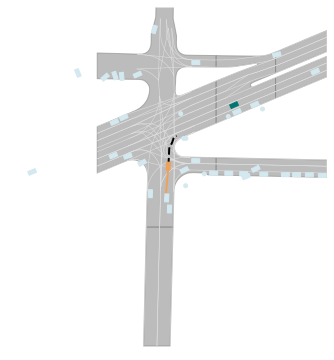

In [22]:
def plot_traj(bounds=80.0):
    plot_bounds = (0, 0, 0, 0)

    _, ax = plt.subplots()

    _plot_static_map_elements(scenario_static_map)
    cur_plot_bounds = _plot_actor_tracks(ax, scenario, 50, None)
    if cur_plot_bounds:
        plot_bounds = cur_plot_bounds
    plt.xlim(
        plot_bounds[0] - bounds,
        plot_bounds[1] + bounds,
    )
    plt.ylim(
        plot_bounds[2] - bounds,
        plot_bounds[3] + bounds,
    )
    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

plot_traj()



In [ ]:
data["agent"]["valid_mask"].sum(-1)

tensor([ 35, 109, 109, 109, 109, 109,   9,  66, 103, 109,  76, 109, 109, 109,
         31, 101,  90,  13,  85,  80,  68,  17, 109, 109,  41, 109,  74, 109,
         24,  32,  40, 109,  11, 109,  81, 109, 109,  34, 109,  10,  90,  62,
        109, 109,  14,  24,  43,  42,  10,  22,  39,  71,  99,  10,  14,  11,
         45,  53,  88,  39,  15,  11,  88,   9,  52,  13,  22,  70,  67,  13,
         20,  64,  63,  53,  62,  62,  62, 109])

In [91]:

from torch_geometric.data import Batch
from torch_geometric.data import HeteroData

if isinstance(data, Batch):
    data["agent"]["av_index"] += data["agent"]["ptr"][:-1]
reg_mask = data["agent"]["predict_mask"][:, model.num_historical_steps :]
cls_mask = data["agent"]["predict_mask"][:, -1]
pred = model(data.cuda())
from utils import wrap_angle
import torch

if model.output_head:
    traj_propose = torch.cat(
        [
            pred["loc_propose_pos"][..., : model.output_dim],
            pred["loc_propose_head"],
            pred["scale_propose_pos"][..., : model.output_dim],
            pred["conc_propose_head"],
        ],
        dim=-1,
    )
    traj_refine = torch.cat(
        [
            pred["loc_refine_pos"][..., : model.output_dim],
            pred["loc_refine_head"],
            pred["scale_refine_pos"][..., : model.output_dim],
            pred["conc_refine_head"],
        ],
        dim=-1,
    )
else:
    traj_propose = torch.cat(
        [
            pred["loc_propose_pos"][..., : model.output_dim],
            pred["scale_propose_pos"][..., : model.output_dim],
        ],
        dim=-1,
    )
    traj_refine = torch.cat(
        [
            pred["loc_refine_pos"][..., : model.output_dim],
            pred["scale_refine_pos"][..., : model.output_dim],
        ],
        dim=-1,
    )

offset = 5

def get_auto_pred(data, pred, offset):
    origin = data["agent"]["position"][:, model.num_historical_steps - 1]
    theta = data["agent"]["heading"][:, model.num_historical_steps - 1]
    cos, sin = theta.cos(), theta.sin()
    rot_mat = theta.new_zeros(data["agent"]["num_nodes"], 2, 2)
    rot_mat[:, 0, 0] = cos
    rot_mat[:, 0, 1] = -sin
    rot_mat[:, 1, 0] = sin
    rot_mat[:, 1, 1] = cos

    # auto_index = data['agent']['valid_mask'][:,model.num_historical_steps]
    data["agent"]["valid_mask"] = (
        torch.cat(
            (
                data["agent"]["valid_mask"][..., offset:],
                torch.zeros(data["agent"]["valid_mask"].shape[:-1] + (offset,)).cuda(),
            ),
            dim=-1,
        )
    ).bool()
    data["agent"]["valid_mask"][:, 0] = False

    new_position = torch.matmul(
        pred["loc_refine_pos"][:, 0, :, :2], rot_mat.swapaxes(-1, -2)
    ) + origin[:, :2].unsqueeze(1)

    input_position = torch.zeros_like(data["agent"]["position"])
    input_position[:, :-offset] = data["agent"]["position"][:, offset:]
    input_position[
        :, model.num_historical_steps - offset : model.num_historical_steps, :2
    ] = new_position[:, :offset]

    input_heading = torch.zeros_like(data["agent"]["heading"])
    input_heading[:, :-offset] = data["agent"]["heading"][:, offset:]
    input_heading[
        :, model.num_historical_steps - offset : model.num_historical_steps
    ] = wrap_angle(pred["scale_refine_pos"][:, 0, :offset, 1] + theta.unsqueeze(-1))

    input_v = torch.zeros_like(data["agent"]["velocity"])
    input_v[:, :-offset] = data["agent"]["velocity"][:, offset:]
    input_v[:, model.num_historical_steps - offset : model.num_historical_steps, :2] = (
        new_position[:, 1:] - new_position[:, :-1]
    )[:, :offset] / 0.1

    data["agent"]["position"] = input_position
    data["agent"]["heading"] = input_heading
    data["agent"]["velocity"] = input_v

    auto_pred = model(data)

    new_origin = data["agent"]["position"][:, model.num_historical_steps - 1]
    new_theta = data["agent"]["heading"][:, model.num_historical_steps - 1]
    new_cos, new_sin = new_theta.cos(), new_theta.sin()
    new_rot_mat = new_theta.new_zeros(data["agent"]["num_nodes"], 2, 2)
    new_rot_mat[:, 0, 0] = new_cos
    new_rot_mat[:, 0, 1] = -new_sin
    new_rot_mat[:, 1, 0] = new_sin
    new_rot_mat[:, 1, 1] = new_cos
    if model.output_head:
        auto_traj_propose = torch.cat(
            [
                auto_pred["loc_propose_pos"][..., : model.output_dim],
                auto_pred["loc_propose_head"],
                auto_pred["scale_propose_pos"][..., : model.output_dim],
                auto_pred["conc_propose_head"],
            ],
            dim=-1,
        )
        auto_traj_refine = torch.cat(
            [
                auto_pred["loc_refine_pos"][..., : model.output_dim],
                auto_pred["loc_refine_head"],
                auto_pred["scale_refine_pos"][..., : model.output_dim],
                auto_pred["conc_refine_head"],
            ],
            dim=-1,
        )
    else:
        new_trans_position_propose = torch.einsum(
            "bijk,bkn->bijn",
            auto_pred["loc_propose_pos"][..., : model.output_dim],
            new_rot_mat.swapaxes(-1, -2),
        ) + new_origin[:, :2].unsqueeze(1).unsqueeze(1)
        trans_position_propose = torch.einsum(
            "bijk,bkn->bijn",
            new_trans_position_propose - origin[:, :2].unsqueeze(1).unsqueeze(1),
            rot_mat,
        )
        trans_heading_propose = (
            auto_pred["scale_propose_pos"][..., model.output_dim - 1]
            + new_theta.unsqueeze(-1).unsqueeze(-1)
            - theta.unsqueeze(-1).unsqueeze(-1)
        )

        auto_traj_propose = torch.cat(
            [
                trans_position_propose,
                pred["scale_propose_pos"][..., : model.output_dim - 1],
                trans_heading_propose[..., None],
            ],
            dim=-1,
        )

        new_trans_position_refine = torch.einsum(
            "bijk,bkn->bijn",
            auto_pred["loc_refine_pos"][..., : model.output_dim],
            new_rot_mat.swapaxes(-1, -2),
        ) + new_origin[:, :2].unsqueeze(1).unsqueeze(1)
        trans_position_refine = torch.einsum(
            "bijk,bkn->bijn",
            new_trans_position_refine - origin[:, :2].unsqueeze(1).unsqueeze(1),
            rot_mat,
        )
        trans_heading_refine = (
            auto_pred["scale_refine_pos"][..., model.output_dim - 1]
            + new_theta.unsqueeze(-1).unsqueeze(-1)
            - theta.unsqueeze(-1).unsqueeze(-1)
        )

        auto_traj_refine = torch.cat(
            [
                trans_position_refine,
                pred["scale_refine_pos"][..., : model.output_dim - 1],
                trans_heading_refine[..., None],
            ],
            dim=-1,
        )

    new_data = data
    return (
        new_data,
        auto_pred, 
        auto_traj_refine,
        auto_traj_propose,
        (new_trans_position_propose, new_trans_position_refine),
    )

pi = pred['pi']
new_data = data
auto_pred = pred
auto_traj_refine = traj_refine.detach()
auto_traj_propose = traj_propose.detach()
gt = torch.cat(
    [
        data["agent"]["target"][..., : model.output_dim],
        data["agent"]["target"][..., -1:],
    ],
    dim=-1,
)

for i in range(model.num_future_steps,offset):
    l2_norm = (torch.norm(auto_traj_propose[..., :2] -
              gt[..., :2].unsqueeze(1), p=2, dim=-1) * reg_mask.unsqueeze(1)).sum(dim=-1)
    best_mode = l2_norm.argmin(dim=-1)
    traj_propose[:,:,i:i+offset]=auto_traj_propose[torch.arange(auto_traj_propose.size(0)),best_mode,:offset].unsqueeze(1)
    traj_refine[:,:,i:i+offset]=auto_traj_refine[torch.arange(auto_traj_refine.size(0)),best_mode,:offset].unsqueeze(1)
          # traj_propose[:,:,i+1:]=auto_traj_propose[:,:,:-(i+1)]
          # traj_refine[:,:,i+1:]=auto_traj_refine[:,:,:-(i+1)]

    new_data, auto_pred, auto_traj_refine, auto_traj_propose, new_position = get_auto_pred(
        new_data, auto_pred, offset
    )


/tmp/ipykernel_1267066/3648957268.py:250: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  vehicle_bounding_box = Rectangle(


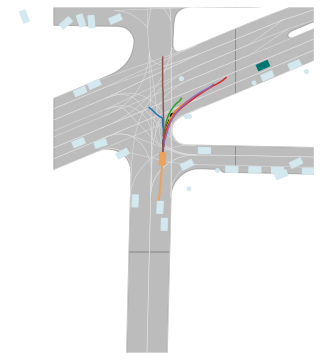

In [92]:
origin = data["agent"]["position"][:, model.num_historical_steps - 1].cpu().detach()
theta = data["agent"]["heading"][:, model.num_historical_steps - 1]
cos, sin = theta.cos(), theta.sin()
rot_mat = theta.new_zeros(data["agent"]["num_nodes"], 2, 2)
rot_mat[:, 0, 0] = cos
rot_mat[:, 0, 1] = sin
rot_mat[:, 1, 0] = -sin
rot_mat[:, 1, 1] = cos

plot_traj(50.0)
for i in range(6):
    
    new_position = torch.matmul(traj_refine[:, :, :, :2].cpu().detach(),
                                 rot_mat.unsqueeze(1).cpu().detach()) + origin[:, :2].reshape(-1, 1, 1, 2)
    xy = new_position[(data["agent"]["category"] == 3).cpu().detach()][0]
    plt.plot(xy[i, ..., 0], xy[i, ..., 1])



In [ ]:
from typing import List, Tuple

_OBS_DURATION_TIMESTEPS: Final[int] = 50
_PRED_DURATION_TIMESTEPS: Final[int] = 60
_PLOT_BOUNDS_BUFFER_M: Final[float] = 30.0
_PlotBounds = Tuple[float, float, float, float]

def visualize_scenario(
    scenario: ArgoverseScenario,
    scenario_static_map: ArgoverseStaticMap,
    save_path: Path,
    prediction_trajectory: np.array
) -> None:
    """Build dynamic visualization for all tracks and the local map associated with an Argoverse scenario.

    Note: This function uses OpenCV to create a MP4 file using the MP4V codec.

    Args:
        scenario: Argoverse scenario to visualize.
        scenario_static_map: Local static map elements associated with `scenario`.
        save_path: Path where output MP4 video should be saved.
    """
    # Build each frame for the video
    frames: List[Image] = []
    plot_bounds: _PlotBounds = (0, 0, 0, 0)

    for timestep in range(_OBS_DURATION_TIMESTEPS + _PRED_DURATION_TIMESTEPS - 1):
        _, ax = plt.subplots()

        # Plot static map elements and actor tracks
        _plot_static_map_elements(scenario_static_map)
        cur_plot_bounds = _plot_actor_tracks(ax, scenario, timestep, prediction_trajectory)
        
        if cur_plot_bounds:
            plot_bounds = cur_plot_bounds

        # Set map bounds to capture focal trajectory history (with fixed buffer in all directions)
        plt.xlim(
            plot_bounds[0] - _PLOT_BOUNDS_BUFFER_M,
            plot_bounds[1] + _PLOT_BOUNDS_BUFFER_M,
        )
        plt.ylim(
            plot_bounds[2] - _PLOT_BOUNDS_BUFFER_M,
            plot_bounds[3] + _PLOT_BOUNDS_BUFFER_M,
        )
        plt.gca().set_aspect("equal", adjustable="box")

        # Minimize plot margins and make axes invisible
        plt.gca().set_axis_off()
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        plt.margins(0, 0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())

        # Save plotted frame to in-memory buffer
        buf = io.BytesIO()
        plt.savefig(buf, format="png")
        plt.close()
        buf.seek(0)
        frame = img.open(buf)
        frames.append(frame)

    # Write buffered frames to MP4V-encoded video
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    vid_path = str(save_path + f"{scenario_id}.mp4")
    video = cv2.VideoWriter(vid_path, fourcc, fps=10, frameSize=frames[0].size)
    for i in range(len(frames)):
        frame_temp = frames[i].copy()
        video.write(cv2.cvtColor(np.array(frame_temp), cv2.COLOR_RGB2BGR))
    video.release()

prediction_trajectory = xy.numpy()
save_path = "/home/guanren/Multi-agent-competitive-environment/videos/"
visualize_scenario(scenario, scenario_static_map, save_path, prediction_trajectory)

/tmp/ipykernel_1072910/2713347193.py:249: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  vehicle_bounding_box = Rectangle(


[1, 2, 3]
